# <center>CSC420 Project  <br><br> Homography using RANSAC<br> <br> Student Number: 1002572236 <br><br>Name: Danil Redko</center>


                                                                                           

Let's start by importing the needed libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import cv2
from scipy.spatial.distance import euclidean as euc
import random
from numpy.linalg import eig, svd, norm
from matplotlib.patches import ConnectionPatch

In [2]:
cover = cv2.imread('data/DVDcovers/the_incredibles.jpg')[:,:,::-1]
test = cv2.imread('data/test/image_05.jpeg')[:,:,::-1]

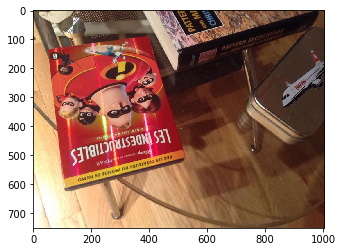

In [3]:
plt.imshow(test)
plt.show()

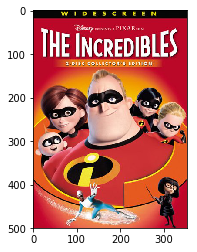

In [4]:
plt.imshow(cover)
plt.show()

Let's get the interesting points using SIFT algorithm. The code is taken from CSC420 Tutorial:

In [5]:
def get_interest_points(img):

    sift = cv2.xfeatures2d.SIFT_create()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kp, des = sift.detectAndCompute(gray, None)
    return kp, des

Now, in order to compute homography we need to find the matches. 

In [6]:
def match_images(im1, im2):
    
    
    
    MAX_FEATURES = 500
    GOOD_MATCH_PERCENT = 0.15

    # Convert images to grayscale
    im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)

    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)

    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)

    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Transform the keypoints lists into numpy array
    points1 = np.array(points1)
    points2 = np.array(points2)

    '''
    # Get all coordinates and create one matrix that
    contains all the matches coordinates, in the format
    # x_i, y_i, x_j, y_j where: i is the 
    coordinates of matches of the first image, 
    # j coordinates in the second image
    '''
    matches = np.concatenate((points1, points2), axis=1)
    
    return matches

Once we have all the matches' coordinates stored in the matrix, let's visualize the result by drawing lines between every match we have found.

In [7]:
def draw_lines_between_matches(img1, img2, matches):
    
    f=plt.figure(figsize=(100,200))
    
    #Set two plots side by side.
    ax1 = f.add_subplot(1, 2, 1)
    ax1.imshow(img1)
    ax1.set_zorder(1)
    ax2 = f.add_subplot(1, 2, 2)
    ax2.imshow(img2)
    
    # Loop through all the matches in the image and 
    #draw a line between match using a random color:
    
    for i in range(0, matches.shape[0]):
        
        #Read coordinate of each match in both images:  i is the first image,
        #j is the second image
        x_i, y_i, x_j, y_j = matches[i]
        
        xy1 = (x_i,y_i)
        xy2 = (x_j,y_j)
        
        #Get a random color for the line for a better visualization 
        color = '#'+'%06X' % randint(0, 0xFFFFFF)
        
        # Using ConnectionPatch draw a line between two subplots, 
        # each plot uses its own coordinate system 
        line = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA='data', coordsB='data',
                              axesA=ax1, axesB=ax2, color=color, linewidth=10)
        ax1.add_artist(line)
        
    plt.show()
    

In [8]:
def plot_rect(p1,p2,p3,p4,color,linewidth=2):
    
    #Simple function to draw a rectangle using 4 points, 
    #width of a line can be specified.

    plt.plot((p1[0], p2[0]), (p1[1], p2[1]), c=color, linewidth=linewidth)
    plt.plot((p1[0], p3[0]), (p1[1], p3[1]), c=color, linewidth=linewidth)
    plt.plot((p2[0], p4[0]), (p2[1], p4[1]), c=color, linewidth=linewidth)
    plt.plot((p3[0], p4[0]), (p3[1], p4[1]), c=color, linewidth=linewidth)

Now, when we have a matrix of the matches: 

We need to compute the homography. 

# Ah = 0 <br>

where $A$ is $2n \times 9$ <br> <br>

$h$ is $9 \times 1$ <br><br>

So we have a system of equations in the following form : <br><br>

$\begin{bmatrix}
    x_{1} & y_{1} & 1 & 0 & 0 & 0 & -x^{'}_{1}x_{1} & -x^{'}_{1}y_{1} & -x^{'}_{1} \\
    0 & 0 & 0 & x_{1} & y_{1} & 1 & -y^{'}_{1}x_{1} & -y^{'}_{1}y_{1} & -y^{'}_{1} \\
       & & & & &\vdots \\
    x_{n} & y_{n} & 1 & 0 & 0 & 0 & -x^{'}_{n}x_{n} & -x^{'}_{n}y_{n} & -x^{'}_{n} \\
    0 & 0 & 0 & x_{n} & y_{n} & 1 & -y^{'}_{n}x_{n} & -y^{'}_{n}y_{n} & -y^{'}_{n}
\end{bmatrix}$ $\begin{bmatrix} h_{00} \\h_{01}\\h_{02}\\h_{10}\\h_{11}\\h_{12}\\h_{20}\\h_{21}\\h_{22} \end{bmatrix}$ =  $\begin{bmatrix} 0 \\ 0 \\ \vdots \\ 0 \\ 0 \end{bmatrix}$

Solution to this system, call it $h$, is given by: Eigenvector of $A^{T}A$ with smallest eigenvalue, $\lambda$.  

<hr>
<h4>*Note</h4>

In the code below: 

$x_i$ corresponds to $x$ <br>

$x_j$ corresponds to $x^{'}$ <br>

Similarly, for y: 

$y_i$ corresponds to $y$ <br>

$y_j$ corresponds to $y^{'}$ <br>


In [9]:
def compute_homography(matches):

    #Create a matrix -  A

    A = []
    
    #Loop through each matches' coordinate and add it to the matrix A.
    
    for i in range(0, matches.shape[0]):

        x_i, y_i, x_j, y_j = matches[i]

        row = [x_i, y_i, 1, 0, 0, 0, -x_j*x_i, -x_j*y_i, -x_j]

        A.append(row)
        
        row = [0, 0, 0, x_i, y_i, 1, -y_j*x_i, -y_j*y_i, -y_j]
        
        A.append(row)

    #Convert a list to numpy array
    A = np.array(A)
    
    '''    
    Eig returns the normalized (unit “length”) eigenvectors,
    such that the column e_vec[:,i] is the eigenvector corresponding to
    #the eigenvalue e_val[i].
    This is taken from the numpy documentation.
    '''
    #Get eigenvalues and eigenvectors of A.T*A
    e_val, e_vec = eig(np.matmul(A.T, A))
    
    #get the index of the smallest eigen value and return corresponding
    #eigen-vector, reshape to 3 by 3. 

    h = e_vec[:, np.argmin(e_val)].reshape(3, 3)

    return h

Use matrix $H$ to map the given point to the test image.

In [10]:
def match_point_homography(x, y, H):
    
    """
    
    point is a match of on the reference image
    
    H is a homography matrix (given by compute_homography function)
    
    returns a coordinates of the match on the test image
    
    """
    
    vector = np.array([x, y, 1]) 
    
    result = np.matmul(H, vector) # Gets a column vector of the form [ax', ay', a]

    new_x, new_y , _ = result / result[-1] # Divide the vector by a to get x and y
    
    return new_x, new_y


Now, we can map the points of the DVD cover to the points on reference image. 

In [11]:
def transform_image(img1, img2, H, color_of_line, line_width, title):
    
    img1x, img1y, _ = img1.shape
        
    f = plt.figure(figsize=(50,50))
    '''
    Get coordinates of 4 corners from the given DVD cover, 
    Apply the Homography transformation to get the point on the reference image
    '''
    p1 = match_point_homography(0, 0 , H)
    p2 = match_point_homography(0.0, img1x, H)
    p3 = match_point_homography(img1y, 0.0, H)
    p4 = match_point_homography(img1y, img1x, H)
    
    #Show image and draw a rectangle based on 4 calculated points 
    plt.imshow(img2)
    plot_rect(p1, p2, p3, p4, color_of_line, line_width)
    plt.title(title, fontsize=50)
    plt.axis('off')
    plt.show()  
    

Now, we are ready to implement RANSAC algorithm to find the 'best' homography, by 'best' we mean the homography matrix with the highest number of inliers.

In [12]:
def RANSAC(matches):
    
    # Initialize the variables that we need to keep track of 

    best_inliers = 0
    
    best_H  = None
    
    for i in range(0, 1000):
        
        #Take a random sample of size 4 out of all matches 
        
        SampleMatches = np.array(random.sample(matches, 4))
        
        # Compute homography matrix H using only 4 matches
        H = compute_homography(SampleMatches)
        
        inliers = 0 

        for match in matches:
            
            # Get coordinates of each match for two images
            
            x_i, y_i, x_j, y_j = match
            
            # Compute new coordinates for reference image
            new_x, new_y = match_point_homography(x_i, y_i, H)
            
    #Compute the difference between where it actually is vs
    #the point we got by applying homography transformation 
            error = norm(np.array([x_j - new_x, y_j - new_y]))

            if error < 3: # Use threshold of 3, stated in the lecture.
                
                # There is an inlier if the error is less than the threshold
                inliers += 1 
        
        # Keep track of which sample gives the greatest number of inliers 
        if inliers > best_inliers: 
            
            best_inliers = inliers 

            best_H = H
    
    #Return matrix H that gives the highest number of inliers as well as 
    #the number of inliers.
    
    return best_H, best_inliers

Let's test the code. First, we get a matrix of matches. 

In [13]:
matches = match_images(cover, test)

We can visualize the matches by drawing lines between the images, where each line represents a match.

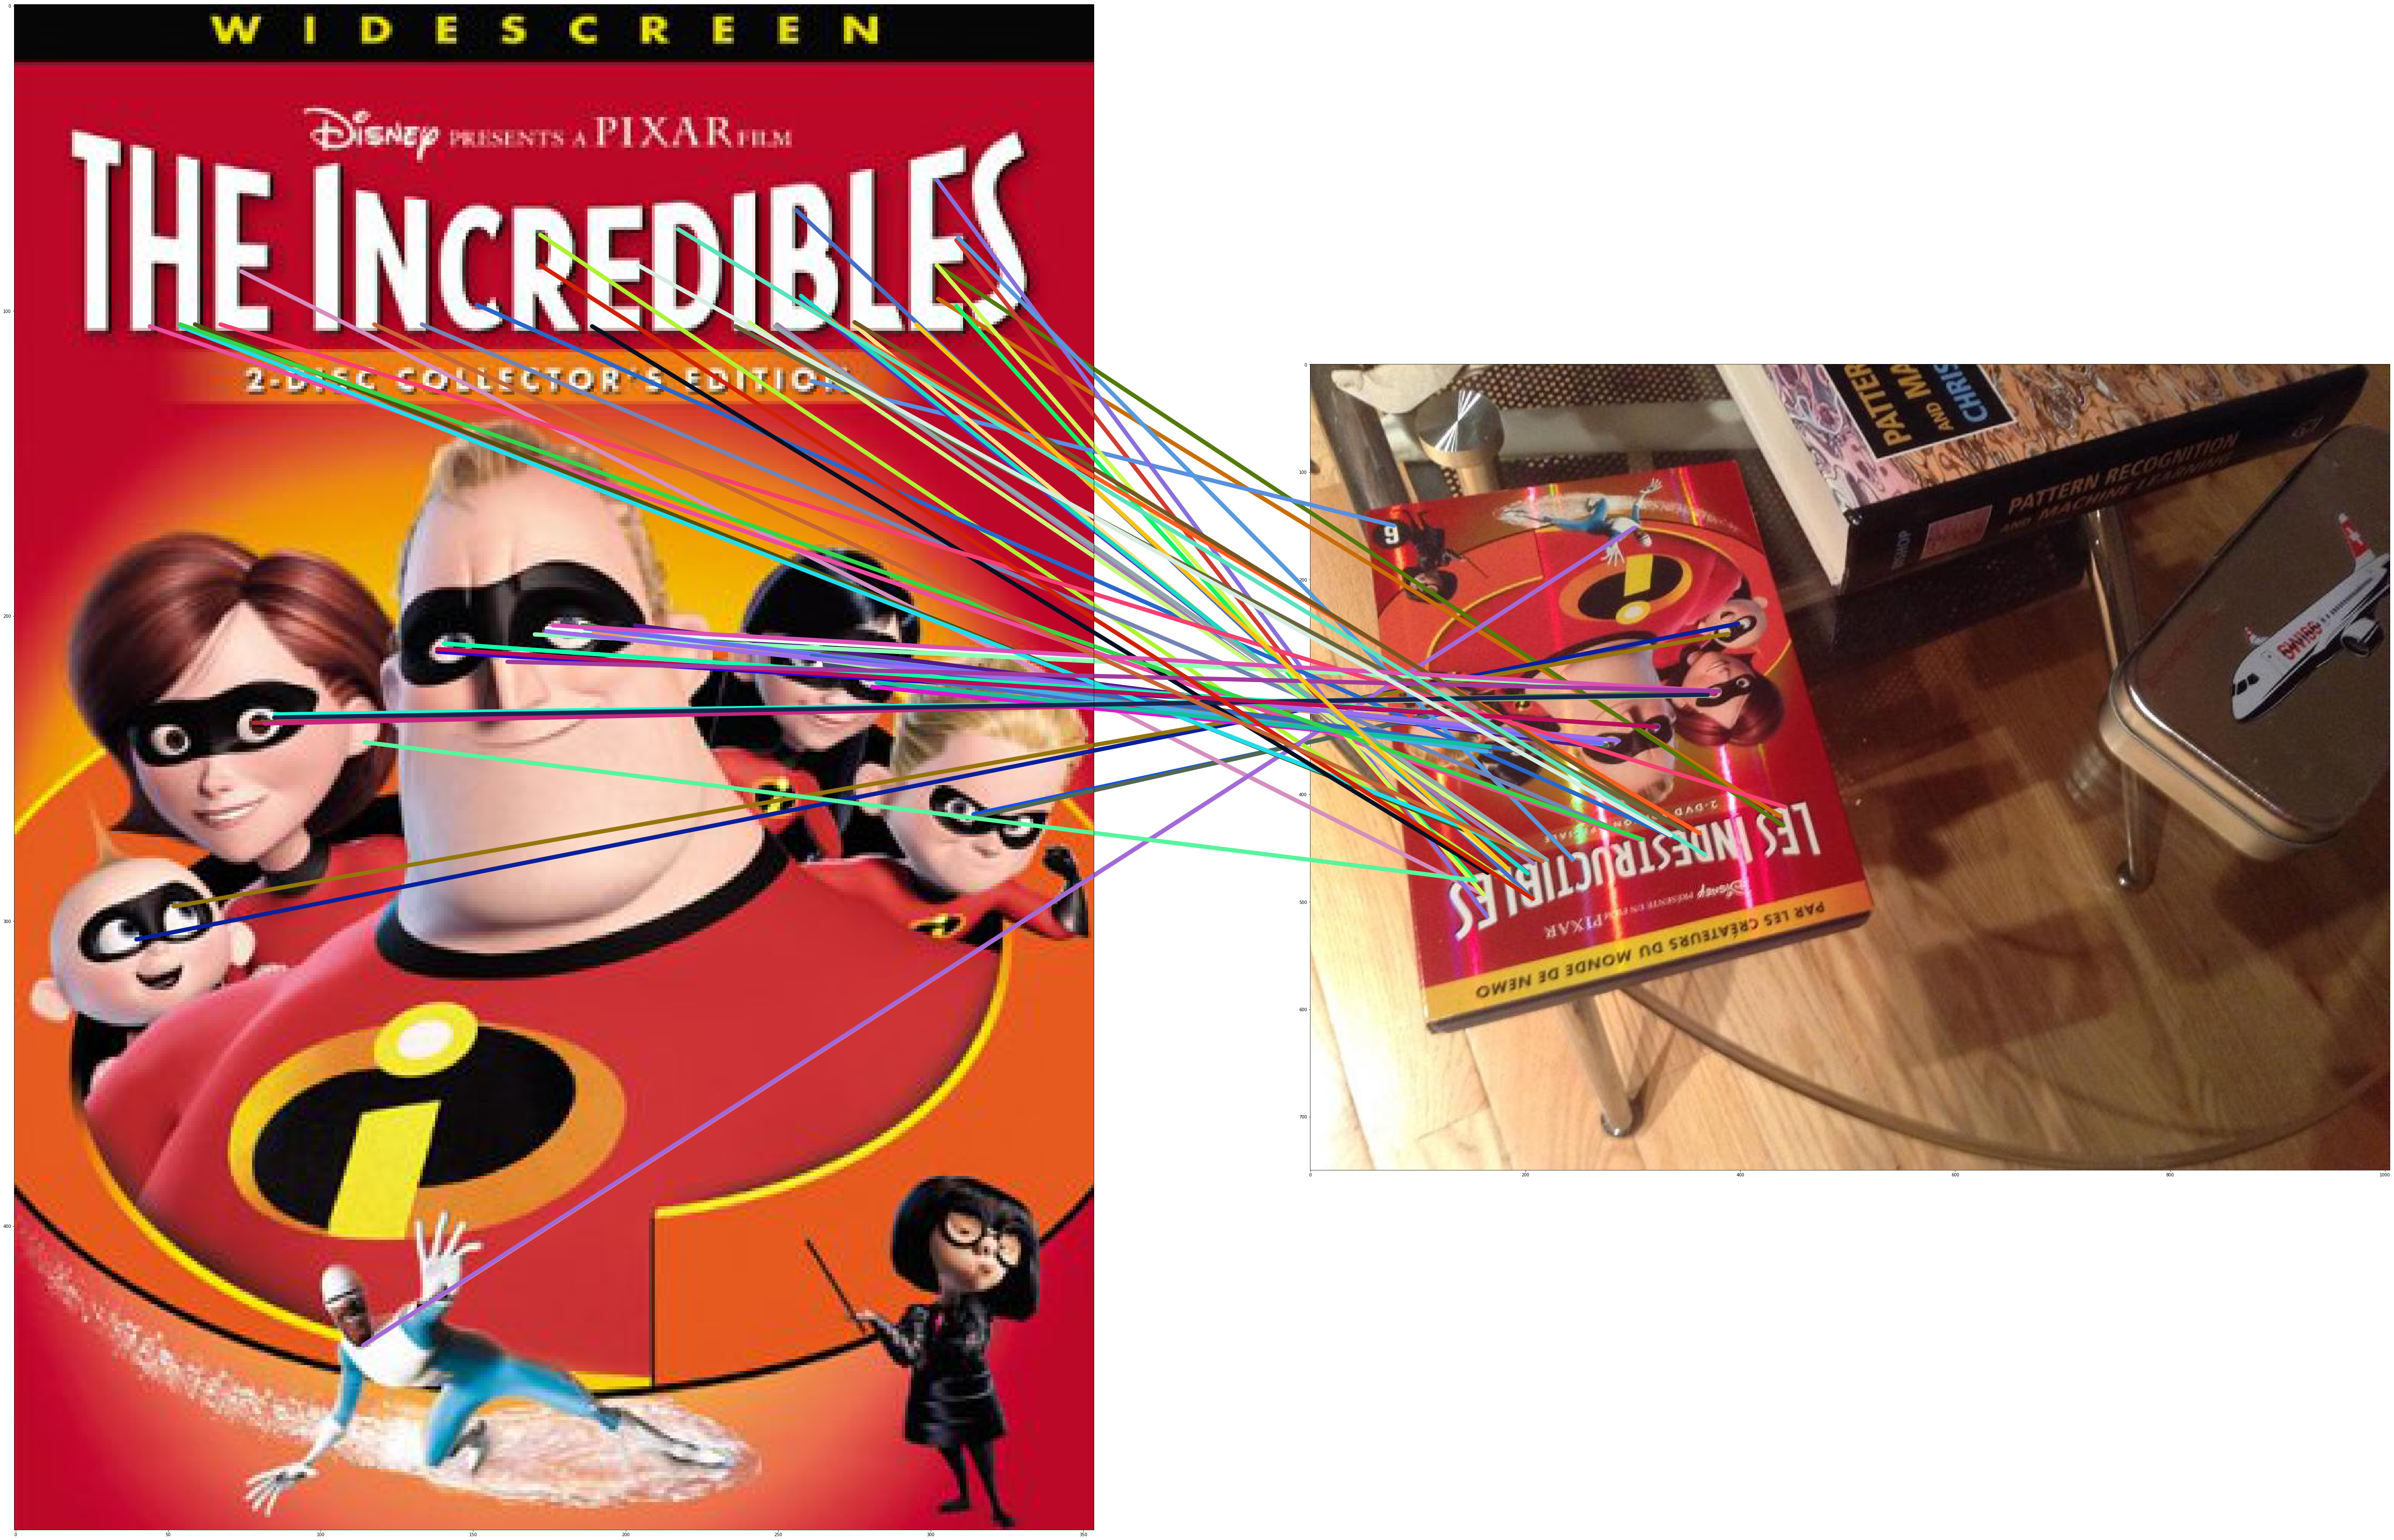

In [14]:
draw_lines_between_matches(cover, test, matches)

Now, let's visualize homography transformation. 

First, we use the matrix H we computed using our code.

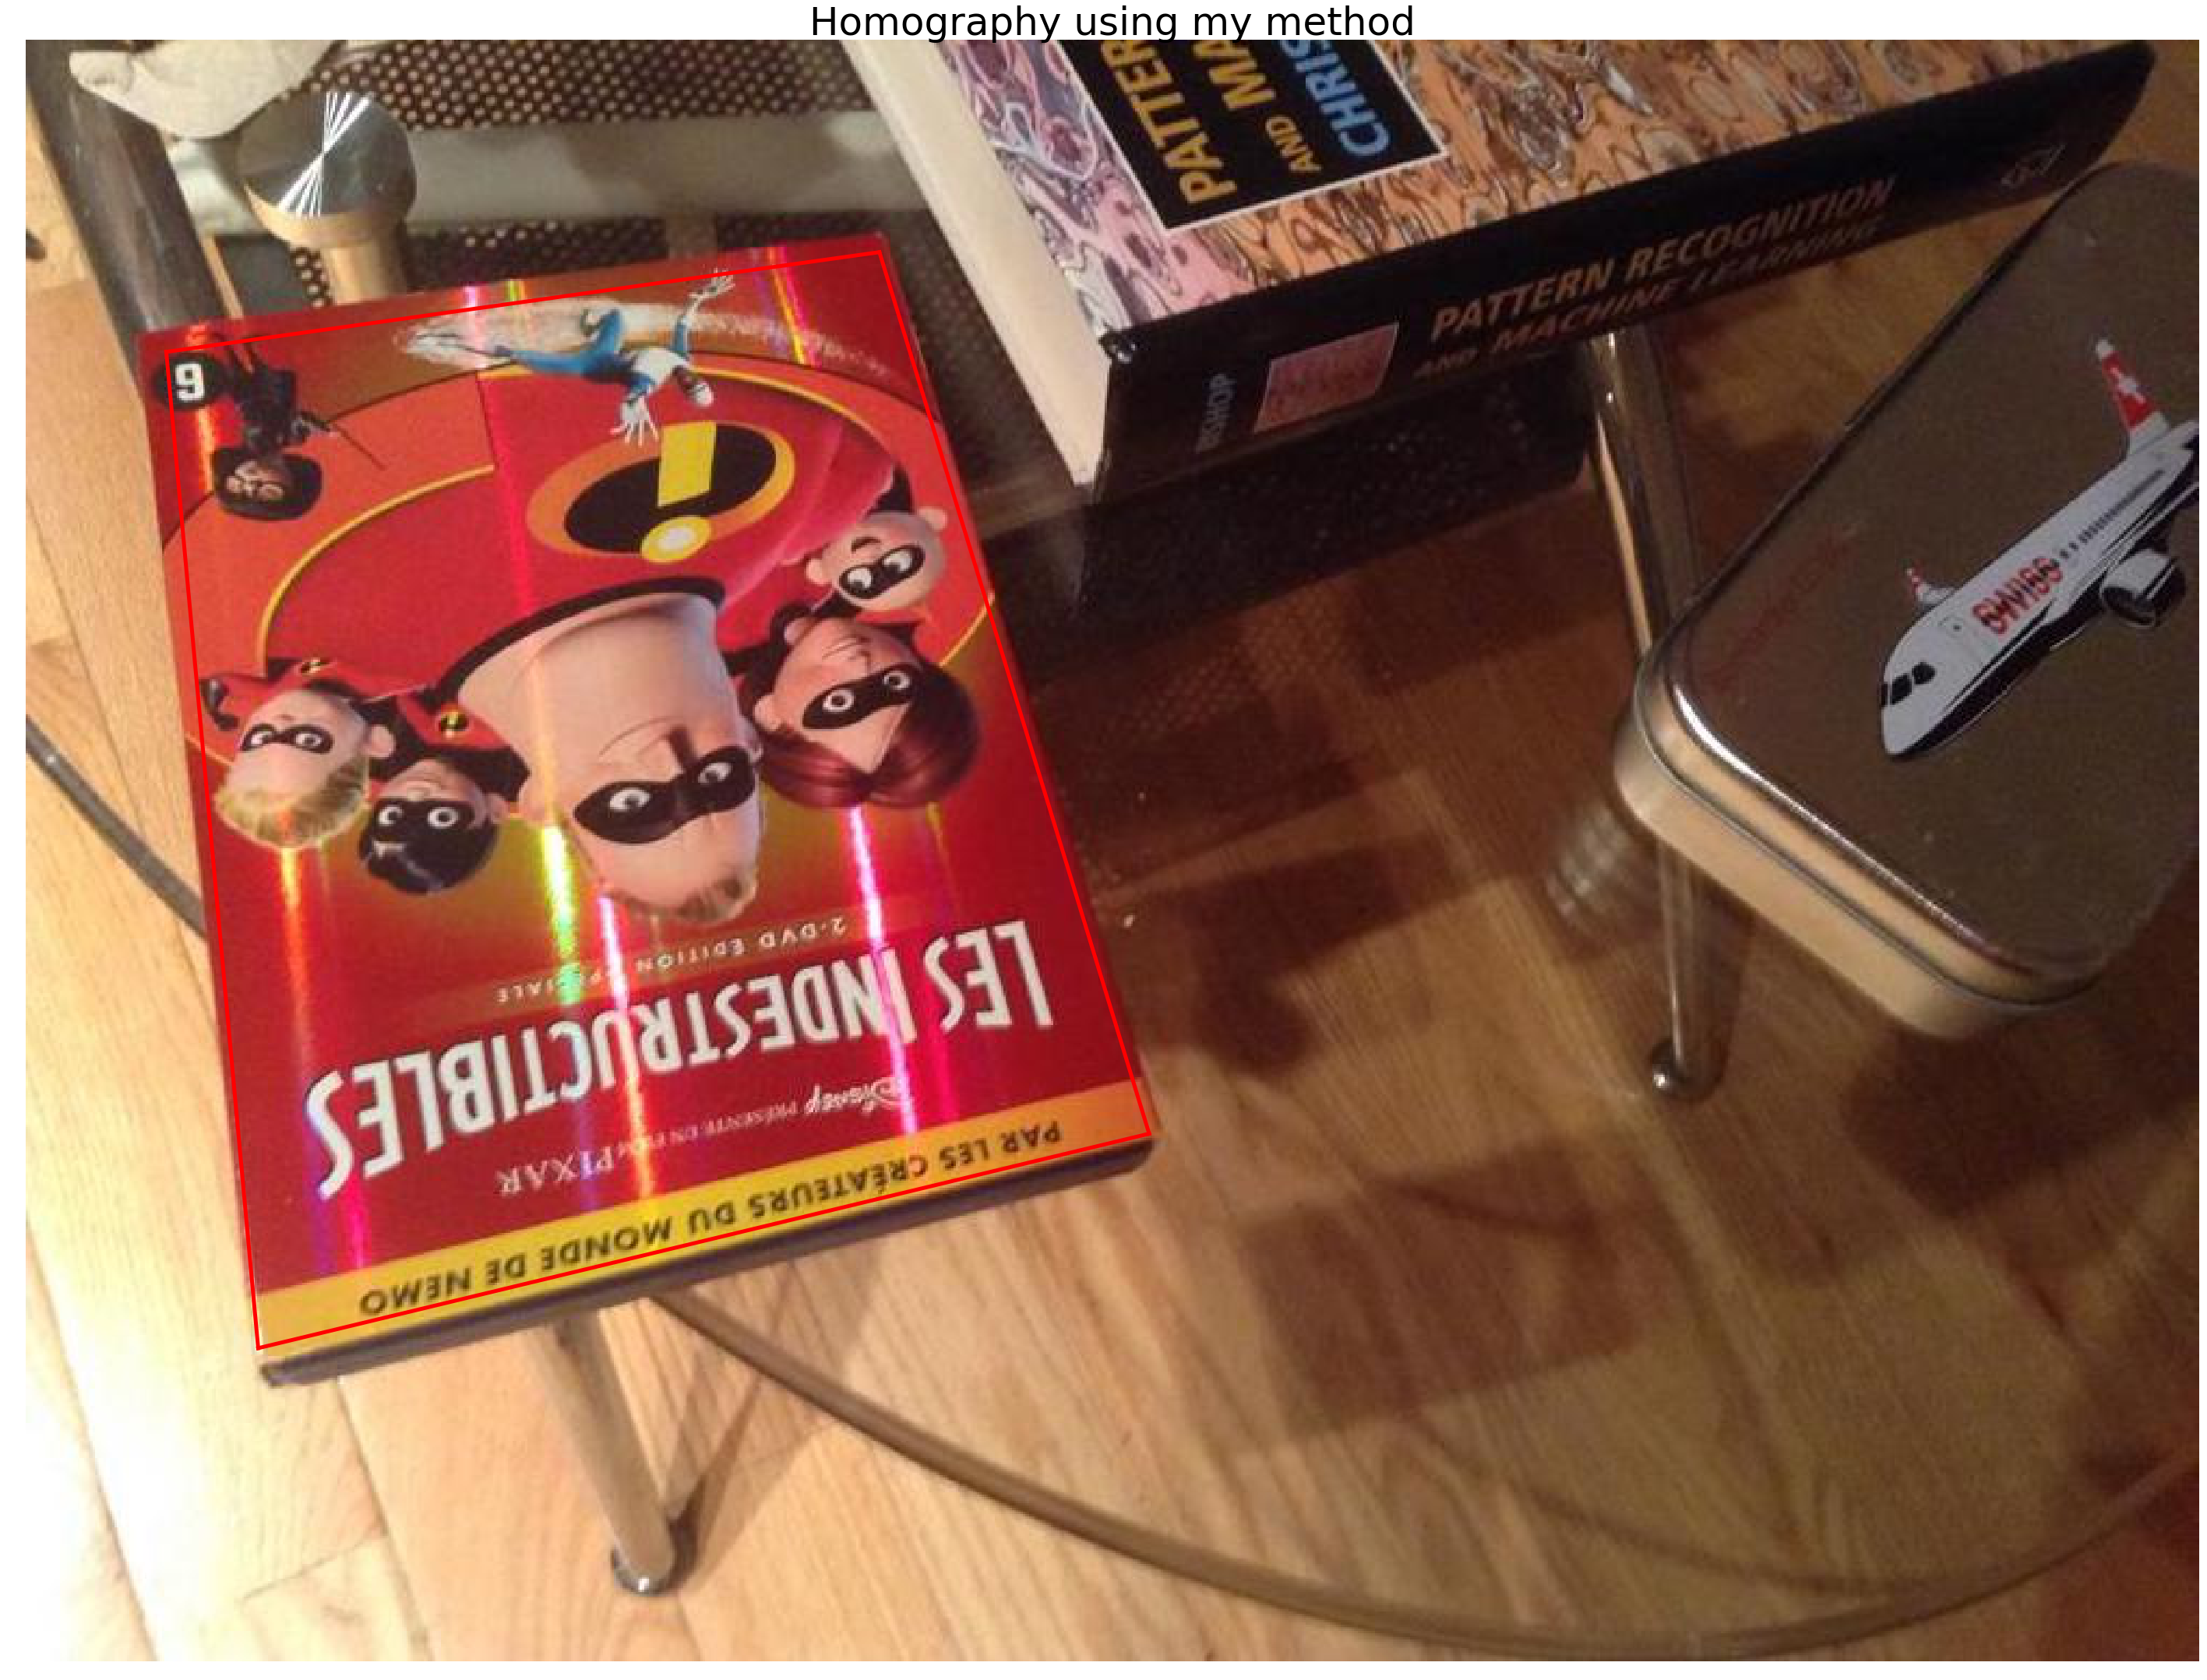

The number of inliers: 36


In [15]:
myH, number_of_inliers = RANSAC(matches)
transform_image(cover, test, myH, 'red', 5, 'Homography using my method')
print('The number of inliers: {}'.format(number_of_inliers))

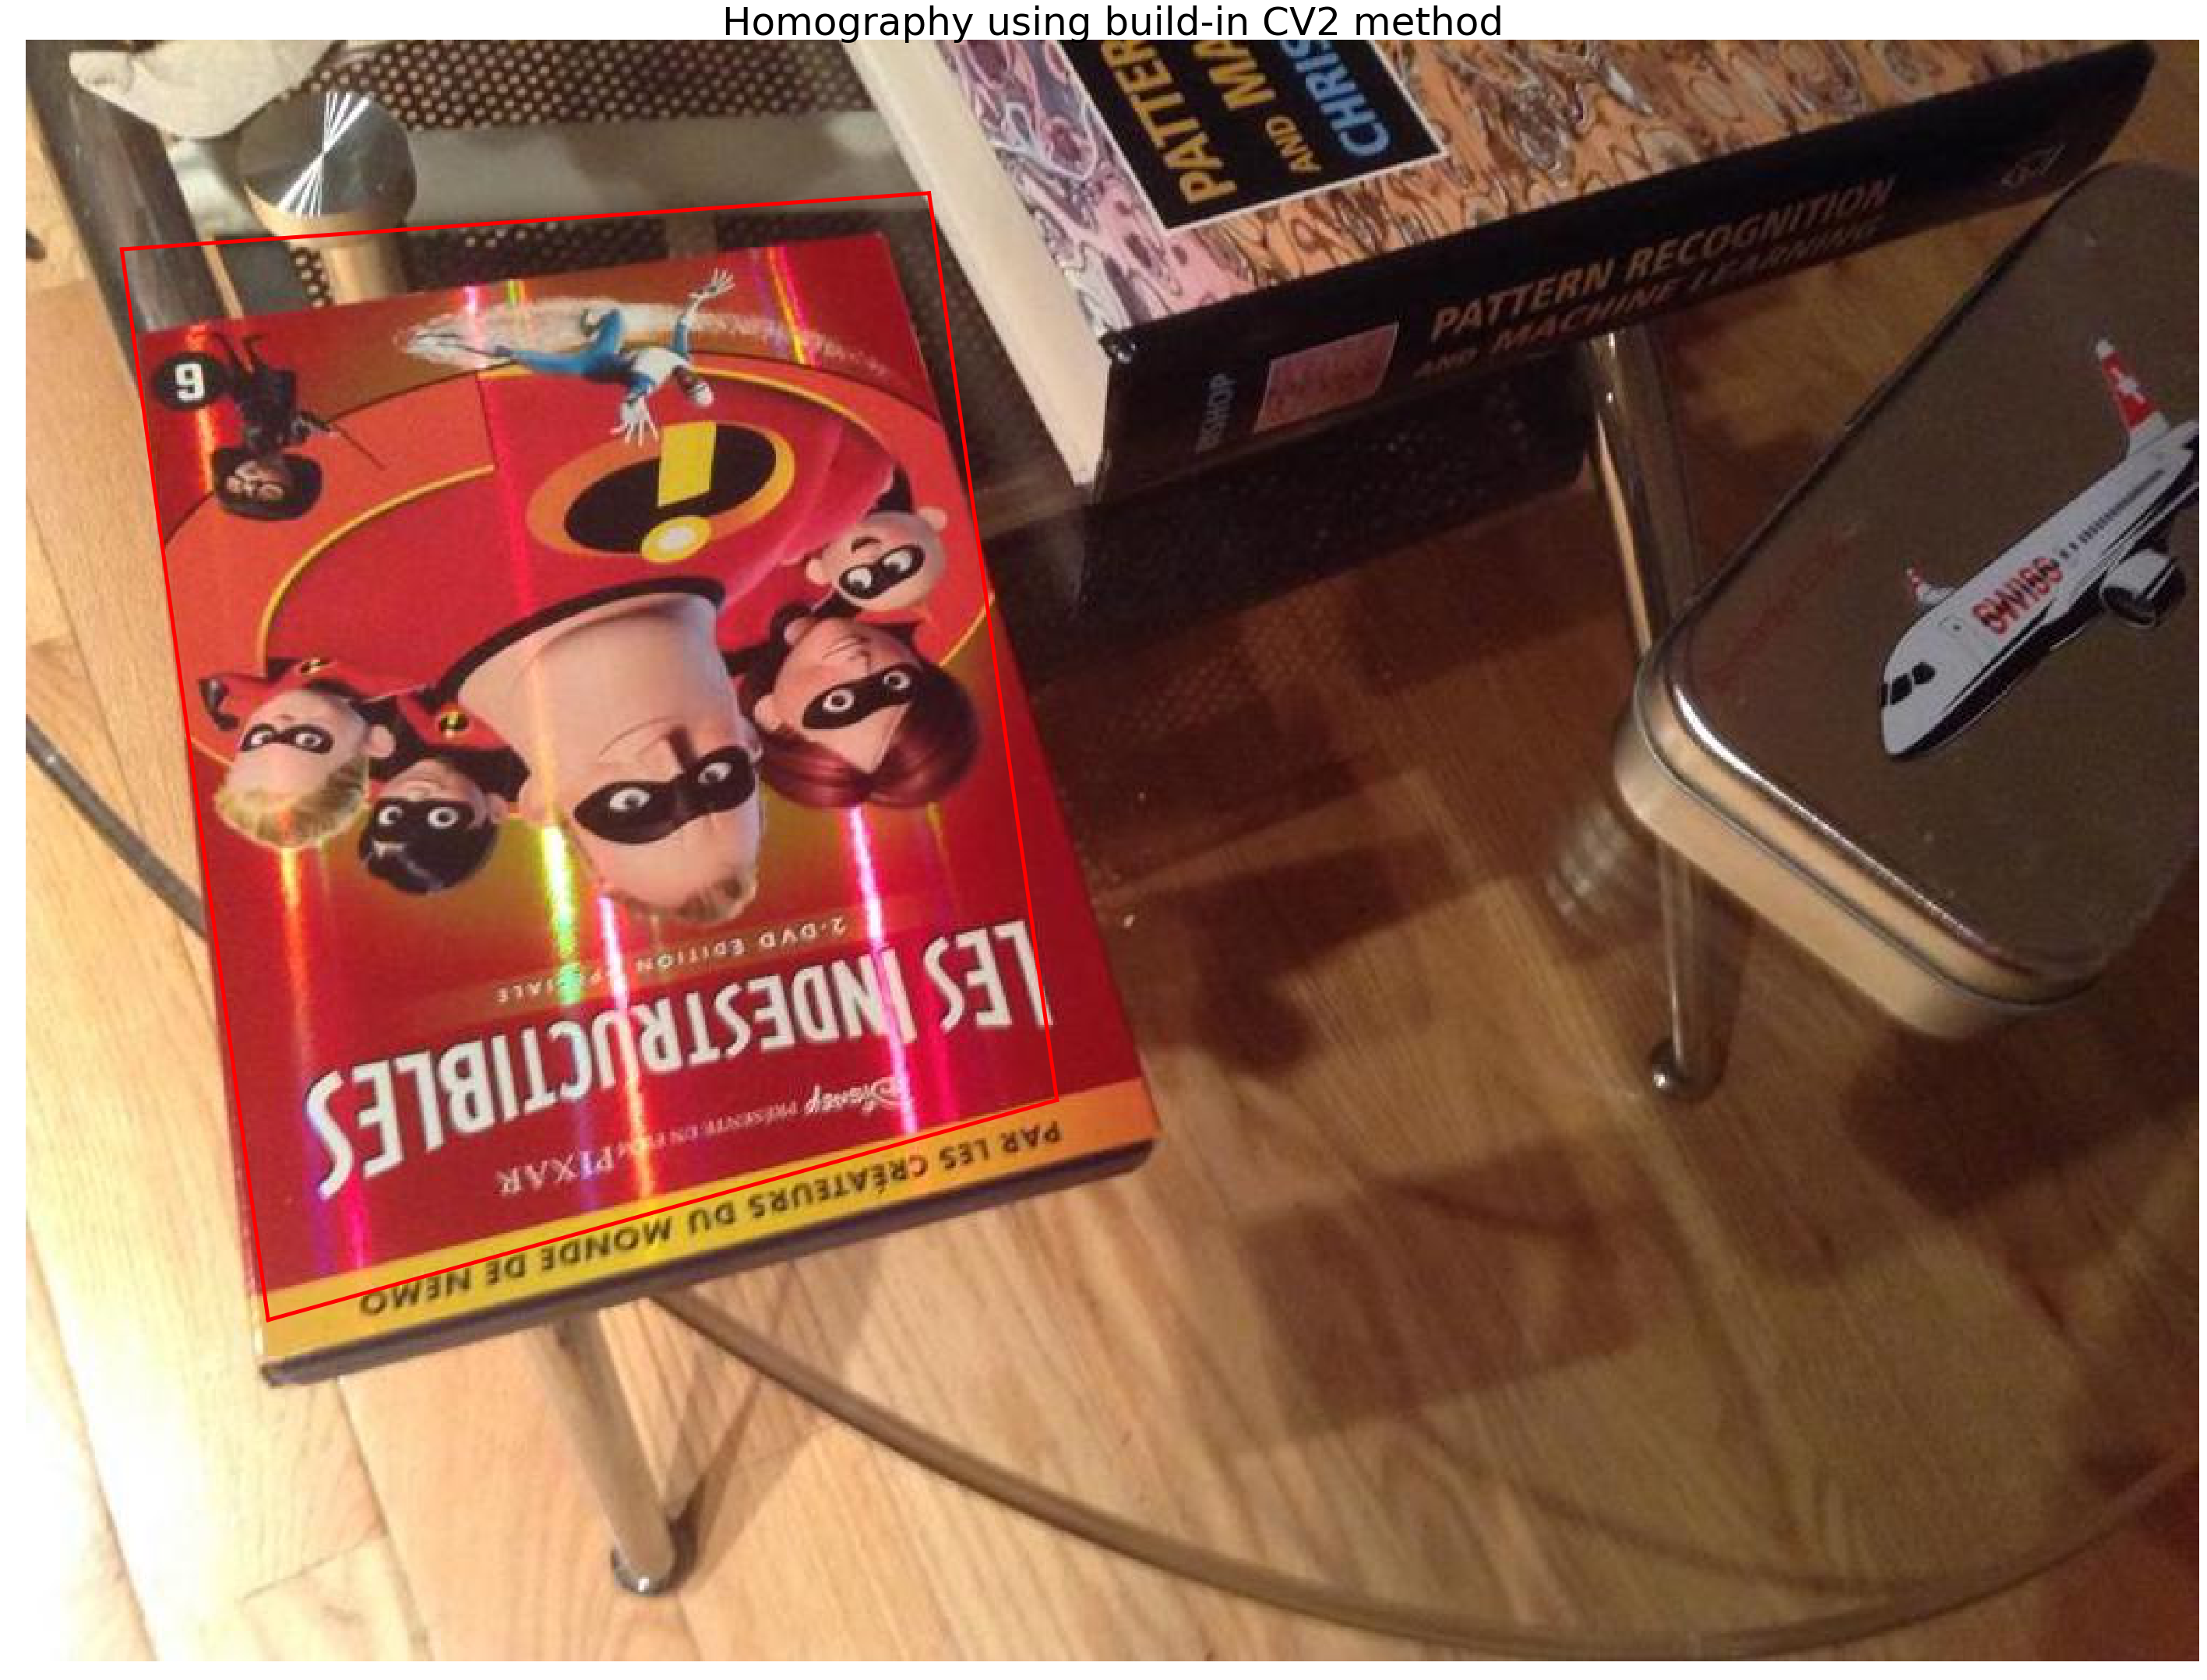

In [17]:
H, _ = cv2.findHomography(matches[:,[0,1]], matches[:,[2,3]], cv2.RANSAC)
transform_image(cover, test, H, 'red', 5, 'Homography using build-in CV2 method')

As we can see the results look identical.<br>
REFERENCE FOR THE CODE FOR MATCHING https://www.learnopencv.com/image-alignment-feature-based-using-opencv-c-python/